In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [4]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [5]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [6]:
start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2022-04-29')

gland = web.DataReader('GLAND.NS', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

gland.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 356 entries, 2020-11-20 to 2022-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       356 non-null    float64
 1   Low        356 non-null    float64
 2   Open       356 non-null    float64
 3   Close      356 non-null    float64
 4   Volume     356 non-null    int64  
 5   Adj Close  356 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 19.5 KB


In [7]:
gland.head()

High          Low         Open        Close    Volume  \
Date                                                                       
2020-11-20  1850.000000  1700.000000  1710.000000  1819.550049  11310647   
2020-11-23  2183.449951  1840.000000  1844.000000  2089.050049   3893237   
2020-11-24  2174.800049  1960.199951  2110.000000  2048.500000   1961368   
2020-11-25  2222.000000  2036.099976  2077.000000  2053.000000   2771893   
2020-11-26  2155.899902  2070.000000  2074.399902  2106.699951   1211725   

              Adj Close  
Date                     
2020-11-20  1819.550049  
2020-11-23  2089.050049  
2020-11-24  2048.500000  
2020-11-25  2053.000000  
2020-11-26  2106.699951

In [8]:
hurst(gland)

array([0.54595427, 0.55543363, 0.55069715, 0.55090642, 0.06874953,
       0.55090642])

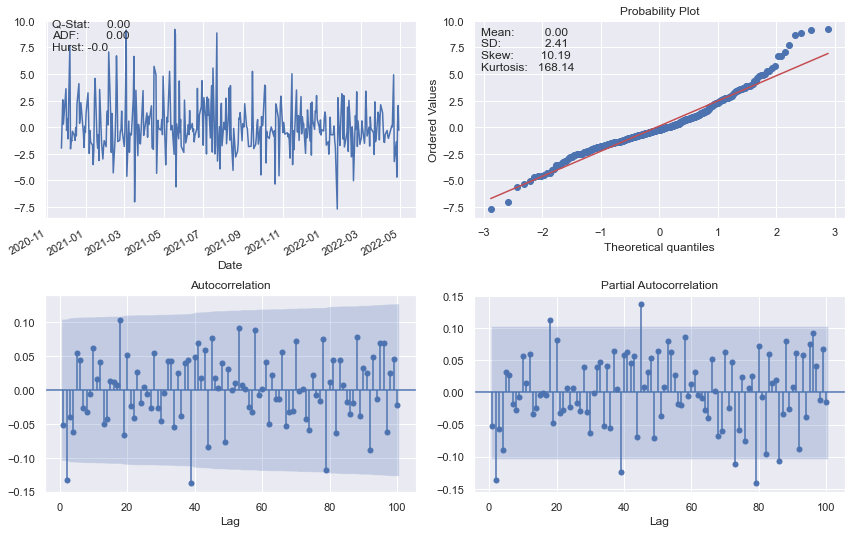

In [42]:
# Calculate daily returns as percentage price changes
gland['Return'] = 100 * (gland['Close'].pct_change())
gland['Log_Return'] = np.log(gland['Close']).diff().mul(100) # rescale to faciliate optimization
gland = gland.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
# plot_correlogram(sun['Log_Return'], lags=100, title='Gland Pharmaceuticals Industries Log Return')
plot_correlogram(gland['Log_Return'], lags=100)

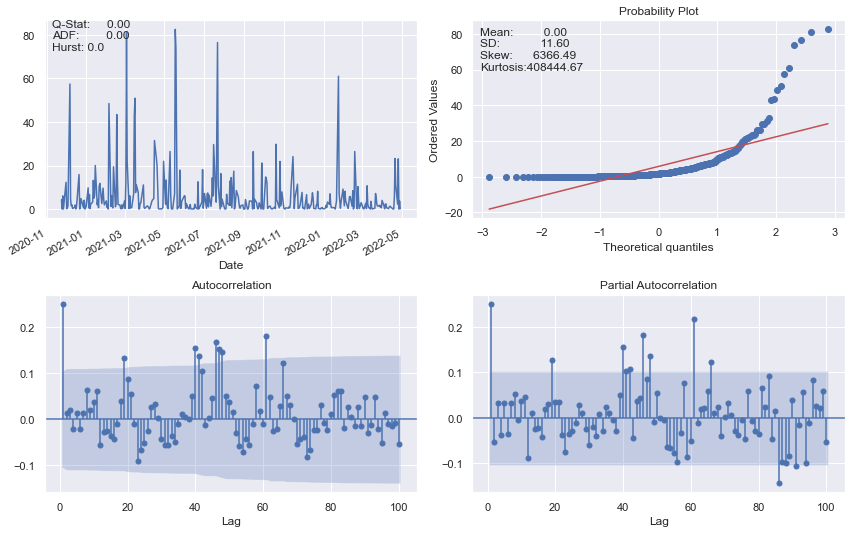

In [43]:
# plot_correlogram(sun['Log_Return'].sub(sun['Log_Return'].mean()).pow(2), lags=100, title='Gland Pharmaceuticals Industries Daily Volatility')
plot_correlogram(gland['Log_Return'].sub(gland['Log_Return'].mean()).pow(2), lags=100)

In [44]:
# Calculate daily std of returns
std_daily = gland['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.44%

Monthly volatility: 11.16%

Annual volatility: 38.66%


In [45]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

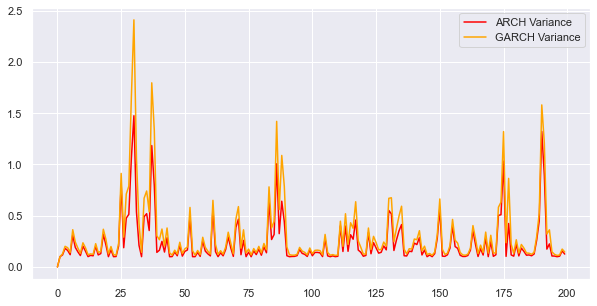

In [46]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

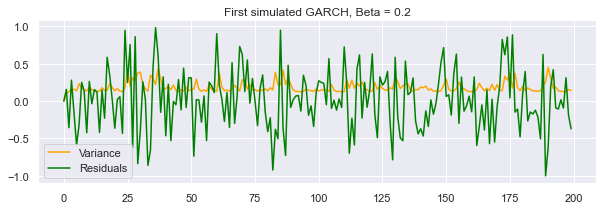

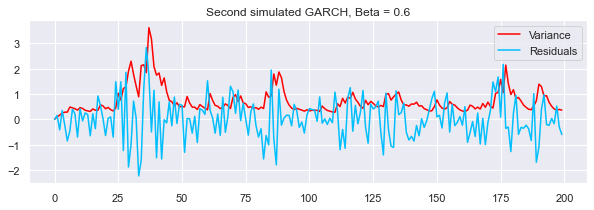

In [47]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

In [48]:
# Specify GARCH model assumptions
basic_gm = arch_model(gland['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     26,   Neg. LLF: 807.1054002473109
Iteration:      8,   Func. Count:     46,   Neg. LLF: 807.0938250595293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 807.0937955856662
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11


In [49]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -807.094
Distribution:                  Normal   AIC:                           1622.19
Method:            Maximum Likelihood   BIC:                           1637.66
                                        No. Observations:                  354
Date:                Tue, May 31 2022   Df Residuals:                      353
Time:                        10:38:48   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1714      0.129      1.324      0.185 [-8.22

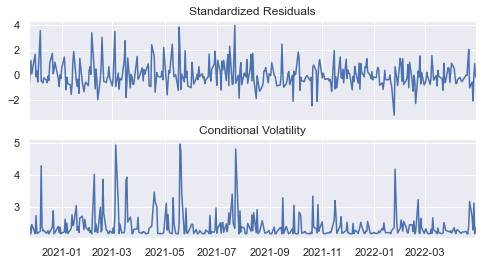

In [50]:
# Plot fitted results
gm_result.plot()
plt.show()

In [51]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1       h.2       h.3       h.4      h.5
Date                                                       
2022-04-29  4.638008  5.629473  5.851172  5.900745  5.91183


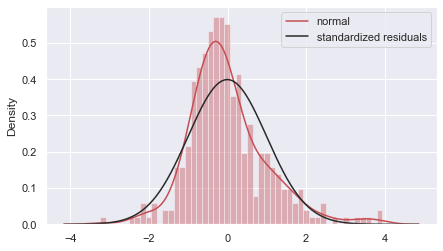

In [52]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [53]:
# Specify GARCH model assumptions
skewt_gm = arch_model(gland['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

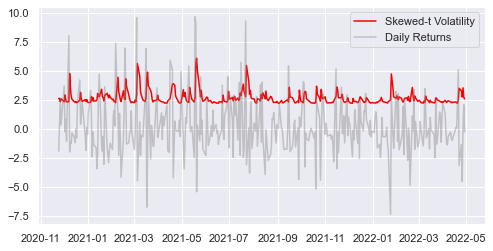

In [54]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(gland['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [55]:
import pmdarima as pm

model = pm.auto_arima(gland['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=1638.721, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1633.003, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=1637.999, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=1637.679, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=1637.984, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.202 seconds


In [56]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  354
Model:                        SARIMAX   Log Likelihood                -813.567
Date:                Tue, 31 May 2022   AIC                           1629.134
Time:                        10:38:55   BIC                           1633.003
Sample:                             0   HQIC                          1630.673
                                - 354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.8040      0.303     19.170      0.000       5.211       6.397
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                91.57
Prob(Q):                              0.32   Pr

In [57]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=gland['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

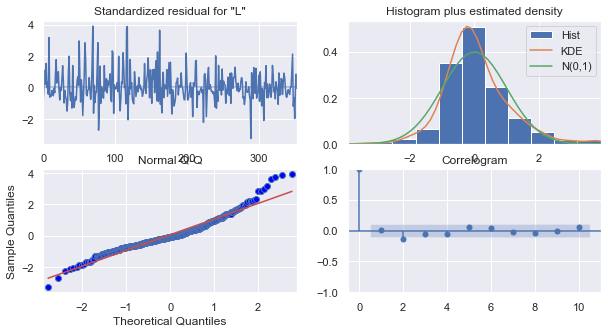

In [58]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [59]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -803.933
Distribution:                  Normal   AIC:                           1613.87
Method:            Maximum Likelihood   BIC:                           1625.47
                                        No. Observations:                  354
Date:                Tue, May 31 2022   Df Residuals:                      354
Time:                        10:38:58   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.5818      1.200      3.817  1.351e-04   [  2.22

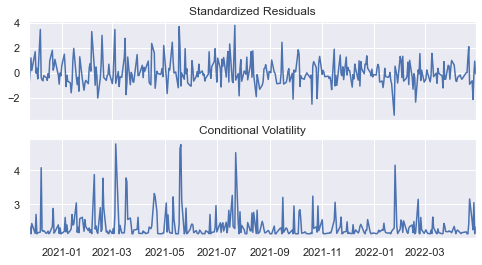

In [60]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

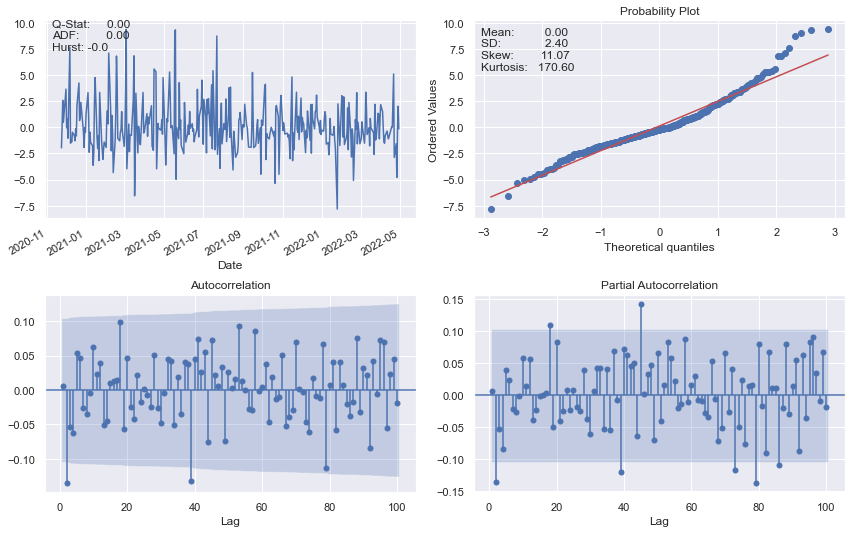

In [61]:
# plot_correlogram(_garch_result.resid.dropna(), lags=100, title='Gland Pharmaceuticals Industries GARCH Residuals')
plot_correlogram(_garch_result.resid.dropna(), lags=100)

In [62]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(gland['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -789.893
Distribution:      Standardized Student's t   AIC:                           1591.79
Method:                  Maximum Likelihood   BIC:                           1615.00
                                              No. Observations:                  354
Date:                      Tue, May 31 2022   Df Residuals:                      353
Time:                              10:39:00   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

In [63]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(gland['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -790.314
Distribution:      Standardized Student's t   AIC:                           1592.63
Method:                  Maximum Likelihood   BIC:                           1615.84
                                              No. Observations:                  354
Date:                      Tue, May 31 2022   Df Residuals:                      353
Time:                              10:39:01   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

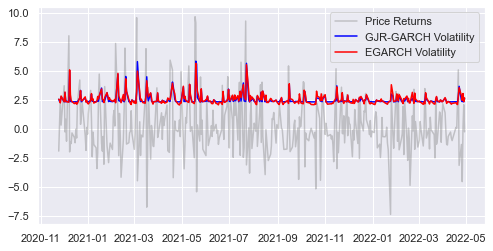

In [64]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(gland['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [65]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 1615.002343699992

EGARCH BIC: 1615.843275077906


In [66]:
index = gland.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [67]:
index = gland.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


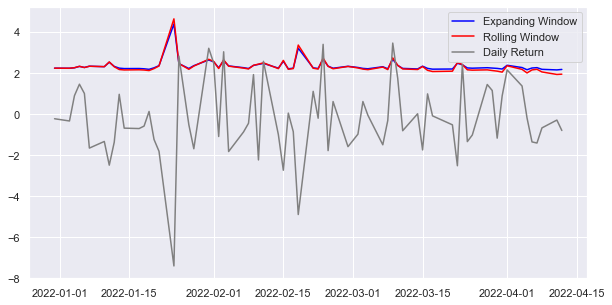

In [68]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(10,5))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(gland.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [69]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter   p-value
mu         0.171423  0.185382
omega      4.592380  0.000269
alpha[1]   0.223607  0.016109
beta[1]    0.000000  1.000000


In [70]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6    lag_7  \
P-values  0.831754  0.095778  0.141023  0.090582  0.111797  0.137647  0.17797   

             lag_8     lag_9    lag_10  
P-values  0.243182  0.316127  0.295212

In [71]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

Empty DataFrame
Columns: []
Index: [P-values]

In [72]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -807.0937955856662
Log-likelihood of skewt GARCH : -778.2781313600708


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [74]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(gland['Return'].sub(gland['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 6.862
Mean Squared Error (MSE): 140.109


(6.862334611064236, 140.10879090111246)